In [1]:
import gc_analysis
from gc_analysis import utils

In [2]:
wildtype = gc_analysis.read_tsv("./data/wt_freq.tsv")
wildtype.head()

,res 1,number 1,res 2,number 2,frequency
0,PRO,386,SER,163,0.583
1,PHE,385,SER,177,0.930
2,PHE,117,SER,351,0.265
3,TYR,317,TYR,92,0.965
4,PRO,342,SER,122,0.805


In [3]:
_df = gc_analysis.select(
    wildtype,
     [(317, 318, 319), (92, 97)],
    kind="selection",)
_df

,res 1,number 1,res 2,number 2,frequency
3,TYR,317,TYR,92,0.965
56,TYR,318,TYR,92,0.575
69,ARG,97,TYR,317,0.738
94,ARG,97,PHE,319,0.632
211,ARG,97,TYR,318,0.184


In [4]:
wildtype_h3 = gc_analysis.select(
    wildtype, 
    [(1,215), (313,321)],
    kind="range",
)
wildtype_h3.head()

,res 1,number 1,res 2,number 2,frequency
3,TYR,317,TYR,92,0.965
5,LEU,47,TYR,318,0.885
22,TYR,318,TYR,50,0.937
26,PHE,319,TYR,37,0.973
29,ARG,97,ASP,316,0.555


In [5]:
mashup = gc_analysis.read_tsv("./data/mt_freq.tsv")
mashup_h3 = gc_analysis.select(mashup, [(1,215), (313,321)])
mashup_h3.head()

,res 1,number 1,res 2,number 2,frequency
0,PHE,319,TYR,36,0.496
1,GLN,55,TYR,318,0.664
3,ASP,320,GLN,55,0.234
10,TYR,318,TYR,49,0.690
15,GLN,89,PHE,319,0.033


In [6]:
merged_df = utils.merge_on_number([wildtype_h3, mashup_h3])
merged_df.columns = ["wildtype", "mutant"]
merged_df = utils.sort_index(merged_df)
merged_df.tail()

,,wildtype,mutant
47,320,0.087,0.000
50,320,0.000,0.000
55,320,0.000,0.234
56,320,0.000,0.040
57,320,0.000,0.001


In [7]:
sequences = utils.sequencer(
    "./data/wt.parm7",
    "./data/mt.parm7",
)
sequences.columns = ["wildtype", "mutant"]

for column in sequences.columns:
    sequences[column] = sequences[column].astype(str).str.capitalize() + sequences.index.map(lambda x: f"{x:03d}")

In [8]:
merged_df = utils.label_merged(merged_df, sequences)
merged_df

wildtype  mutant
wildtype wildtype mutant mutant                  
Ser030   Tyr317   Ser030 Tyr317     0.000   0.000
Ser031   Tyr317   Ser031 Tyr317     0.000   0.005
         Tyr318   Ser031 Tyr318     0.000   0.002
Ser032   Tyr317   Tyr032 Tyr317     0.004   0.000
Tyr033   Tyr318   Leu033 Tyr318     0.000   0.001
...                                   ...     ...
Leu047   Asp320   Leu047 Asp320     0.087   0.000
Tyr050   Asp320   Ala050 Asp320     0.000   0.000
Arg055   Asp320   Gln055 Asp320     0.000   0.234
Ala056   Asp320   Ser056 Asp320     0.000   0.040
Thr057   Asp320   Gly057 Asp320     0.000   0.001

[141 rows x 2 columns]

In [9]:
CUTOFF = 0.6

rel_cut = merged_df[merged_df.max(axis=1) - merged_df.min(axis=1) > CUTOFF]
abs_cut = merged_df[merged_df > CUTOFF]

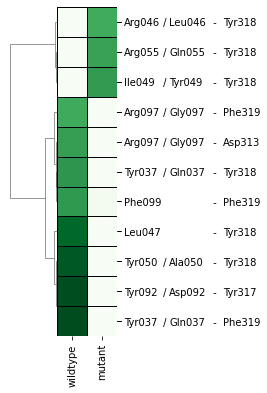

In [10]:
finger = gc_analysis.fingerprint(rel_cut)

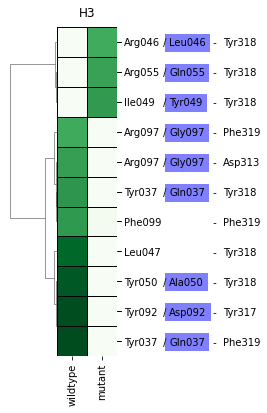

In [11]:
finger.set_title("H3")
finger.align_labels(factor=0.6)
finger.color_labels(["none", "blue"])
finger.fig

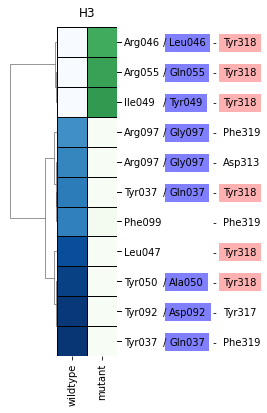

In [12]:
finger.recolor_matrix(["Blues", "Greens"], gc_analysis.utils.mask_gen(1,1))
for label in finger.ax.get_yticklabels():
    if label.get_text() == "Tyr318":
        label.set_bbox(dict(facecolor="red", alpha=0.3, ec='none'))
finger.fig

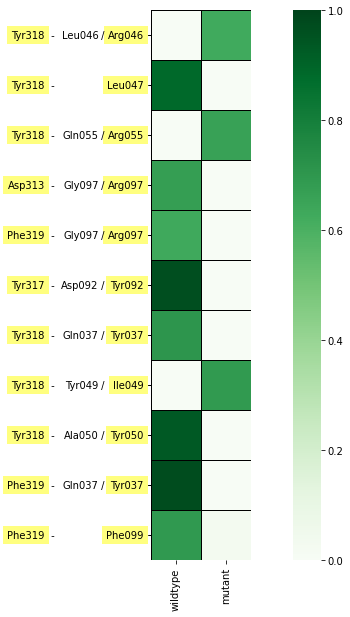

In [13]:
hm = gc_analysis.heatmap(rel_cut)
hm.fig.set_size_inches(hm.fig.get_size_inches()*0.5)
hm.align_labels(factor = -0.6)
hm.color_labels(["yellow"])


In [14]:
cut_wt = utils.select_system(rel_cut,"wildtype")

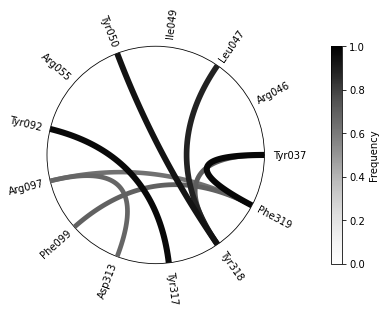

In [15]:
flareplot = gc_analysis.flareplot(cut_wt)

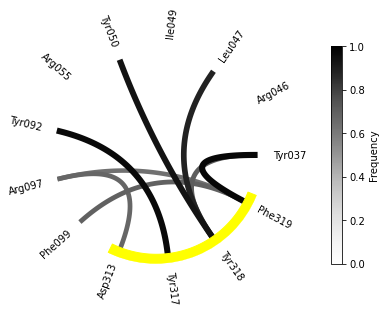

In [16]:
flareplot.mark({"H3" : ("yellow", (313,321)),},
               strategy_name="range",
              )
# flareplot.reset_marking()
# flareplot.ax.set_rlim(top=1.1)
flareplot.fig

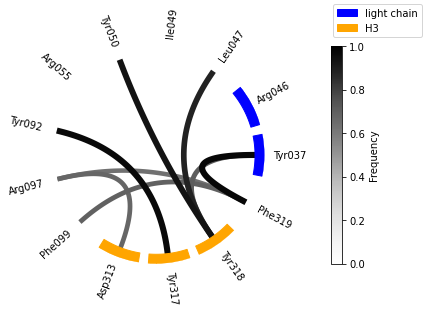

In [17]:
flareplot.mark({"light chain": ("blue", [37, 46]),
                "H3" : ("orange", (313,318)),},
               strategy_name="individual",
               gap_scale=0.1
              )
flareplot.fig.legend()
flareplot.fig

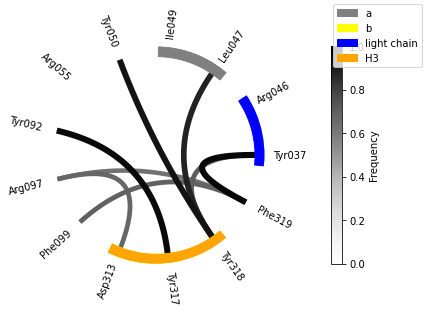

In [18]:
flareplot.mark({"a": ("grey", [47, 49]),
                "b" : ("yellow", (313,317)),
                "light chain": ("blue", [37, 46]),
                "H3" : ("orange", (313,318))},
               strategy_name="range",
              )
flareplot.fig.legend()
flareplot.fig

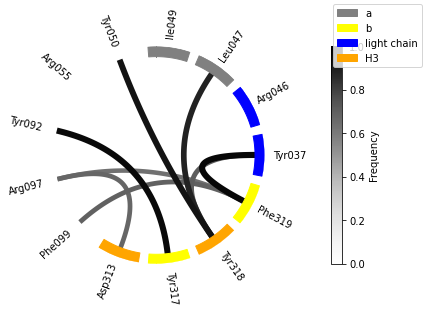

In [19]:
flareplot.mark({"a": ("grey", [47, 49]),
                "b" : ("yellow", (319,317)),
                "light chain": ("blue", [37, 46]),
                "H3" : ("orange", (313,318))},
               strategy_name="selection",
               gap_scale=0.1
              )
flareplot.fig.legend()
flareplot.fig

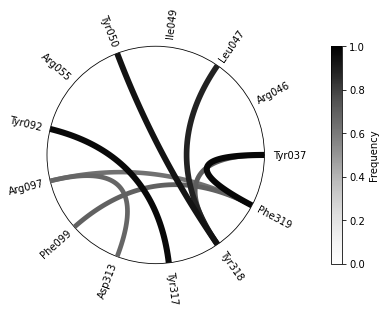

In [20]:
flareplot.reset_marking()
flareplot.fig